In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
PATH = Path('../data/')
TRAIN_PATH = PATH/'train_images'
TEST_PATH_1 = PATH/'leaderboard_test_data'
TEST_PATH_2 = PATH/'leaderboard_holdout_data'

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.4, max_zoom=1.05, max_warp=0., 
                      p_affine=1., p_lighting=0.)

In [5]:
np.random.seed(0)

# train with extra images
src = (ImageItemList.from_csv(PATH, 'extended_train_labels.csv', folder='train_images')
                    .random_split_by_pct(0.2)
                    .label_from_df(cols=1))

In [6]:
bs = 32
data = (src.transform(tfms, size=128)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

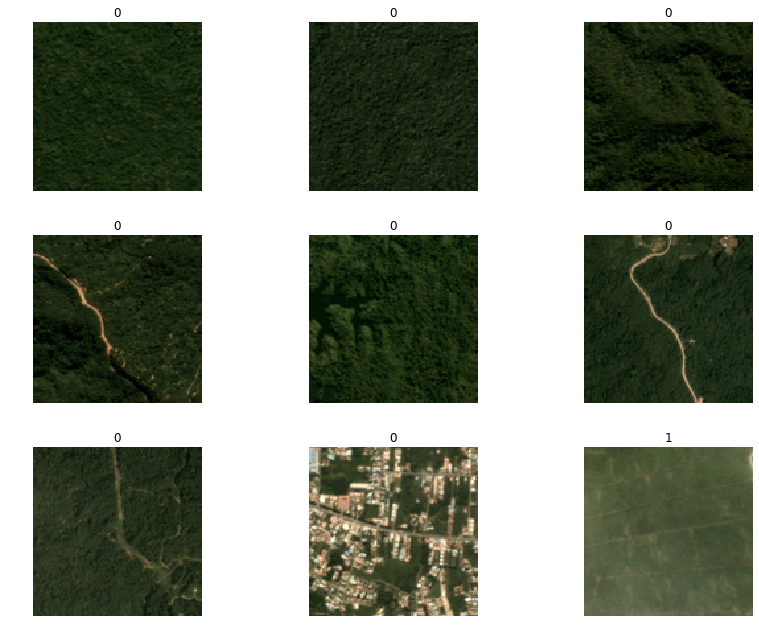

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [8]:
arch = models.resnet50

In [24]:
learn = create_cnn(data, arch, metrics=accuracy)

In [25]:
learn.loss_func = nn.NLLLoss()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [29]:
lr = 1e-2

In [30]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,-1861.886719,-3175.873047,0.983398
2,-29476.035156,-34997.285156,0.990869
3,-72836.226562,-78445.117188,0.991976
4,-100285.187500,-102984.742188,0.994466
5,-106324.515625,-107859.257812,0.994466


In [31]:
learn.save('stage-1-rn50-extraim')

In [32]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy
1,-108479.953125,-108542.789062,0.988932
2,-121412.414062,-123396.171875,0.991976
3,-132455.015625,-133791.687500,0.992529
4,-140141.578125,-139056.359375,0.992252
5,-141033.437500,-139716.390625,0.991976


In [41]:
learn.save('stage-2-rn50-extraim')

In [42]:
data = (src.transform(tfms, size=256)
           .databunch(bs=32)
           .normalize(imagenet_stats))
learn.data = data

In [43]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [46]:
lr=1e-3

In [47]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,-141022.000000,-139943.203125,0.986442
2,-149452.781250,-147833.281250,0.986995
3,-157296.062500,-152725.687500,0.988102
4,-158148.093750,-155818.281250,0.987272
5,-160099.187500,-153437.515625,0.988932


In [48]:
learn.save('stage-1-256-rn50-extraim')

In [49]:
learn.unfreeze()

In [50]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy
1,-160494.328125,-152587.046875,0.970393
2,-160696.484375,-158413.359375,0.992529
3,-162552.781250,-161527.078125,0.991976
4,-163312.546875,-158975.718750,0.993913
5,-164212.750000,-161061.265625,0.993913


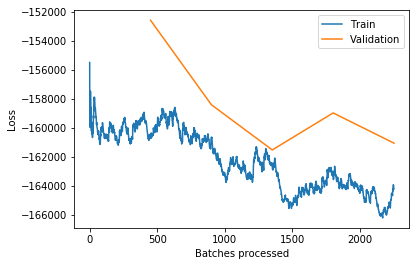

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.save('stage-2-256-rn50-extraim')

# Test

In [53]:
learn = create_cnn(data, arch, metrics=accuracy)

In [54]:
learn = learn.load('stage-2-256-rn50-extraim')

In [55]:
learn.export()

In [56]:
test_1 = ImageItemList.from_folder(TEST_PATH_1)
test_2 = ImageItemList.from_folder(TEST_PATH_2)
len(test_1), len(test_2)

(4356, 2178)

In [57]:
learn_1 = load_learner(PATH, test=test_1)
preds_1, _ = learn_1.get_preds(ds_type=DatasetType.Test)

In [63]:
preds_1

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [58]:
out_1 = preds_1[:, 1]

In [59]:
fnames_1 = [str(f).split('/')[-1] for f in learn_1.data.test_ds.items]
df_1 = pd.DataFrame({'image_id':fnames_1, 'has_oilpalm':out_1}, columns=['image_id', 'has_oilpalm'])

In [64]:
df_1.head(10)

,image_id,has_oilpalm
0,img_006952017.jpg,0.0
1,img_050972018.jpg,1.0
2,img_078702018.jpg,0.0
3,img_043442017.jpg,0.0
4,img_061632017.jpg,0.0
5,img_078692018.jpg,1.0
6,img_080162017.jpg,0.0
7,img_089532017.jpg,0.0
8,img_092182017.jpg,0.0
9,img_006352017.jpg,0.0


In [65]:
learn_2 = load_learner(PATH, test=test_2)
preds_2, _ = learn_2.get_preds(ds_type=DatasetType.Test)

In [66]:
out_2 = preds_2[:, 1]

In [67]:
fnames_2 = [str(f).split('/')[-1] for f in learn_2.data.test_ds.items]
df_2 = pd.DataFrame({'image_id':fnames_2, 'has_oilpalm':out_2}, columns=['image_id', 'has_oilpalm'])

In [68]:
df_2.head(10)

,image_id,has_oilpalm
0,img_087262018.jpg,0.0
1,img_084402018.jpg,0.0
2,img_035082017.jpg,0.0
3,img_004842018.jpg,0.0
4,img_000772018.jpg,0.0
5,img_078032017.jpg,1.0
6,img_041072018.jpg,1.0
7,img_028872017.jpg,0.0
8,img_006342018.jpg,0.0
9,img_029842018.jpg,1.0


In [69]:
df_out = pd.concat([df_1, df_2], axis=0).sort_values('image_id').reset_index(drop=True)

In [70]:
df_out.shape

(6534, 2)

In [71]:
df_out.head(10)

,image_id,has_oilpalm
0,img_000012018.jpg,1.0
1,img_000022018.jpg,0.0
2,img_000032017.jpg,1.0
3,img_000042017.jpg,0.0
4,img_000052017.jpg,0.0
5,img_000062017.jpg,0.0
6,img_000062018.jpg,0.0
7,img_000122017.jpg,0.0
8,img_000132018.jpg,1.0
9,img_000142018.jpg,0.0


In [74]:
df_out.to_csv('./test_output.csv', index=False)